In [191]:
!pip install -r requirements.txt

In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
import numpy as np

import shap
import matplotlib.pyplot as plt

import random



In [27]:
#filepath = 'data_output/district_splits/SLOUGH.parquet'
filepath = 'data_output/clean_features.parquet'
features = pd.read_parquet(filepath)

In [28]:
features.head()

,CORE_price_paid,CORE_deed_date,1HE_district,BACKUP_county,ID_combined_address_x,ID_fuzzy_match,CORE_match_confidence,CORE_BUILDING_REFERENCE_NUMBER,1HE_CURRENT_ENERGY_RATING,1HE_POTENTIAL_ENERGY_RATING,...,AI_MAINHEAT_DESCRIPTION,1HE_MAINHEAT_ENERGY_EFF,AI_MAINHEATCONT_DESCRIPTION,1HE_MAINHEATC_ENERGY_EFF,AI_LIGHTING_DESCRIPTION,1HE_LIGHTING_ENERGY_EFF,1HE_MECHANICAL_VENTILATION,BACKUP_CONSTRUCTION_AGE_BAND,1HE_TENURE,ID_combined_address_y
0,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,D,B,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,Low energy lighting in 73% of fixed outlets,Very Good,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
1,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,D,B,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,Low energy lighting in 53% of fixed outlets,Good,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
2,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,E,E,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,No low energy lighting,Very Poor,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
3,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,D,D,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,No low energy lighting,Very Poor,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
4,655000,2024-12-12,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,67 amersham road nan hp13 5aa,67a amersham road hp13 5aa,90.909091,1.000529e+10,D,C,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,Low energy lighting in all fixed outlets,Very Good,natural,England and Wales: 1930-1949,Owner Occupied,67a amersham road hp13 5aa


In [29]:
encoding_cols = [col for col in features.columns if col.startswith('1HE_')]
core_cols = [col for col in features.columns if col.startswith('CORE_')]
id_cols = [col for col in features.columns if col.startswith('ID_')]
AI_cols = [col for col in features.columns if col.startswith('AI_')]

final_feature_cols = encoding_cols + core_cols
features = features[final_feature_cols]

train = features.loc[features['CORE_deed_date'].dt.year < 2025]
test = features.loc[features['CORE_deed_date'].dt.year >= 2025]

X_train = train[final_feature_cols].drop(columns=['CORE_price_paid', 'CORE_deed_date', 'CORE_INSPECTION_DATE'], axis=1) # I need to drop date here! 
X_test = test[final_feature_cols].drop(columns=['CORE_price_paid','CORE_deed_date', 'CORE_INSPECTION_DATE'], axis=1) # I need to drop date here! 
y_train = train['CORE_price_paid']
y_test = test['CORE_price_paid']


In [30]:
# Train Test Split - Stratified
features['ENRICH_YEAR'] = pd.to_datetime(features['CORE_deed_date']).dt.year
features['stratification_key'] = features['ENRICH_YEAR'].astype(str) + '_' + features['1HE_district']

# Removing any district with a single sale in a particular year (cannot be split):
strat_count = features['stratification_key'].value_counts()
valid_keys = strat_count[strat_count>=2].index
features = features[features['stratification_key'].isin(valid_keys)].copy()

X = features.drop(columns=['CORE_price_paid', 
                           'CORE_deed_date', 
                           'CORE_INSPECTION_DATE', 
                           'ENRICH_YEAR', 
                           'stratification_key'
                           #'CORE_match_confidence',
                           #'CORE_BUILDING_REFERENCE_NUMBER',
                           ])
y = features['CORE_price_paid']

# Stratified Splits - could also try by Year-Month
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=features['stratification_key'],
    random_state=42
)

# Saving Final Features for the RAG database
train_db = X_train.copy()
train_db['TRANSACTION_PRICE'] = y_train
train_db.to_parquet('data_output/RAGdb/RAGdb.parquet')

# Checking the year distribution
print('TRAINING DATA...')
print(features.loc[X_train.index, 'ENRICH_YEAR'].value_counts().sort_index())

print('TEST DATA...')
print(features.loc[X_test.index, 'ENRICH_YEAR'].value_counts().sort_index())

TRAINING DATA...
ENRICH_YEAR
2020    2437
2021    4802
2022    3725
2023    2586
2024    3153
2025    2323
Name: count, dtype: int64
TEST DATA...
ENRICH_YEAR
2020    1044
2021    2059
2022    1597
2023    1108
2024    1351
2025     996
Name: count, dtype: int64


In [31]:
# Writing the stratified train-test splits.
X_train.to_parquet('data_output/prod_features/X_train.parquet')
X_test.to_parquet('data_output/prod_features/X_test.parquet')
y_train.to_frame().to_parquet('data_output/prod_features/y_train.parquet')
y_test.to_frame().to_parquet('data_output/prod_features/y_test.parquet')

In [32]:
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore'),encoding_cols)
],remainder='passthrough')

In [33]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=43,
        n_jobs=-1
    ))
])

In [34]:
print('Training Random Forest...')
pipeline.fit(X_train, y_train)
print('Training Complete')
print(pipeline)

Training Random Forest...
Training Complete
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['1HE_district',
                                                   '1HE_CURRENT_ENERGY_RATING',
                                                   '1HE_POTENTIAL_ENERGY_RATING',
                                                   '1HE_PROPERTY_TYPE',
                                                   '1HE_BUILT_FORM',
                                                   '1HE_ENERGY_TARIFF',
                                                   '1HE_MAINS_GAS_FLAG',
                                                   '1HE_GLAZED_AREA',
                                                   '1HE_HOT_WATER_ENERGY_EFF',
                                            

In [35]:
# Making Predictions on test data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [36]:
# Evaluating
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train,y_train_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

train_mape = round(mean_absolute_percentage_error(y_train,y_train_pred)*100,2)
test_mape = round(mean_absolute_percentage_error(y_test,y_test_pred)*100,2)


print(f'Train RMSE: {train_rmse} \nTest RMSE: {test_rmse} \nTrain MAE:{train_mae} \nTest MAE: {test_mae} \nTrain MAPE: {train_mape}% \nTest MAPE: {test_mape}%')


Train RMSE: 134747.7778439572 
Test RMSE: 268149.12280452694 
Train MAE:66974.44961845096 
Test MAE: 138346.14979110353 
Train MAPE: 9.94% 
Test MAPE: 19.52%


In [37]:
# Saving the model
import joblib

joblib.dump(pipeline, 'models/RF_Naive_Pipeline.pkl')

#loaded_pipeline = joblib.load('models/LR_Pipeline.pkl')
#preds = loaded_pipeline.predict(X_new)

['models/RF_Naive_Pipeline.pkl']

# XGBoost

In [38]:
pipeline_XG = Pipeline([
    ('preprocessor', preprocessor),
    #('feature_selection', SelectFromModel(
    #    XGBRegressor(n_estimators=100, random_state=42),
    #    threshold='0.5*mean' # Test Alternative thresholds.
    #    )), # Validate!
    ('regressor', XGBRegressor(
        n_estimators=1000,
        learning_rate = 0.03,
        max_depth = 7,
        random_state = 42,
        min_child_weight=3, 
        subsample=0.85,
        colsample_bytree=0.8,
        colsample_bylevel=0.85,
        gamma=0.2,
        reg_alpha = 0.1,
        reg_lambda = 2
    ))
])

In [39]:
# Fitting the pipeline
print('Training XGBoost...')
pipeline_XG.fit(X_train, y_train)
print('Training Complete')
print(pipeline)

Training XGBoost...
Training Complete
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['1HE_district',
                                                   '1HE_CURRENT_ENERGY_RATING',
                                                   '1HE_POTENTIAL_ENERGY_RATING',
                                                   '1HE_PROPERTY_TYPE',
                                                   '1HE_BUILT_FORM',
                                                   '1HE_ENERGY_TARIFF',
                                                   '1HE_MAINS_GAS_FLAG',
                                                   '1HE_GLAZED_AREA',
                                                   '1HE_HOT_WATER_ENERGY_EFF',
                                                  

In [40]:
# Predictions
y_train_pred_XG = pipeline_XG.predict(X_train)
y_test_pred_XG = pipeline_XG.predict(X_test)

In [41]:
# Evaluating 

train_rmse_XG = np.sqrt(mean_squared_error(y_train, y_train_pred_XG))
test_rmse_XG = np.sqrt(mean_squared_error(y_test, y_test_pred_XG))

train_mae_XG = mean_absolute_error(y_train,y_train_pred_XG)
test_mae_XG = mean_absolute_error(y_test,y_test_pred_XG)

train_mape_XG = round(mean_absolute_percentage_error(y_train,y_train_pred_XG)*100,2)
test_mape_XG = round(mean_absolute_percentage_error(y_test,y_test_pred_XG)*100,2)


print(f'Train RMSE: {train_rmse_XG} \nTest RMSE: {test_rmse_XG} \nTrain MAE:{train_mae_XG} \nTest MAE: {test_mae_XG} \nTrain MAPE: {train_mape_XG}% \nTest MAPE: {test_mape_XG}%')


Train RMSE: 103290.69131339958 
Test RMSE: 270148.162014847 
Train MAE:70323.5234375 
Test MAE: 135868.796875 
Train MAPE: 12.31% 
Test MAPE: 19.05%


In [42]:
joblib.dump(pipeline, 'models/XGBoost_Naive_Pipeline.pkl')

['models/XGBoost_Naive_Pipeline.pkl']

Important: SHAP values should be used to determine the most contributive features.

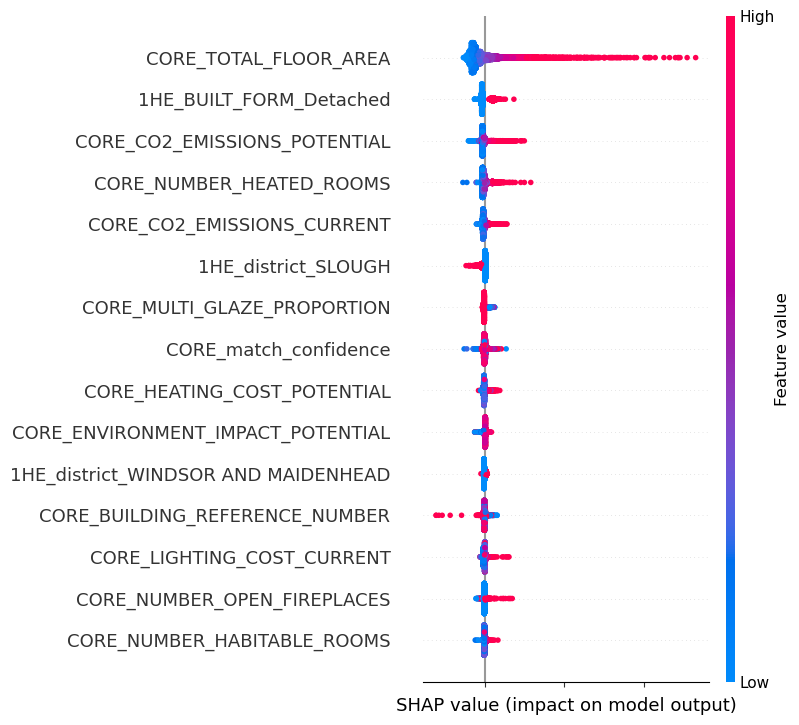

In [43]:
# SHAP Values

X_test_transformed = pipeline_XG.named_steps['preprocessor'].transform(X_test)

# Retrieving the names of the features
raw_names = pipeline_XG.named_steps['preprocessor'].get_feature_names_out()
feature_names = [name.split('__')[-1] for name in raw_names]

# Explaining Model Predictions
explainer = shap.TreeExplainer(pipeline_XG.named_steps['regressor'])
shap_values = explainer(X_test_transformed)
shap_values.feature_names = list(feature_names)

# Visualising
#shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)
#plt.figure(figsize=(12,10))
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    max_display=15,
    show=False
)
#shap.plots.waterfall(shap_values[0], max_display=10)

ax = plt.gca()
ax.set_xticklabels([]) # Removes Overlapping Annotations
#ax.set_xlabel("")

plt.show()

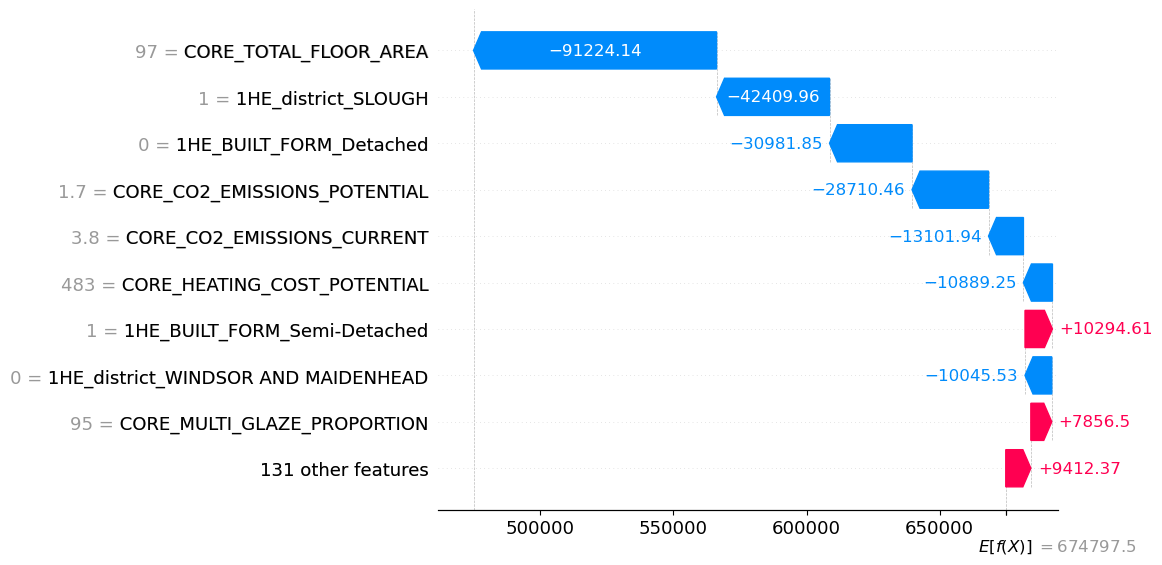

In [44]:
shap.plots.waterfall(shap_values[5], max_display=10,show=False)

ax = plt.gca()

for text in ax.texts:
    text.set_visible(False)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

In [45]:
# Creating SHAP plots for each district - Single Graph
shap_district_avg = []
shap_valid_districts = []
districts = features['1HE_district'].unique()

for district in districts:
    # Shap Values for the specific district
    name = f'shap_{district}' 
    mask = (X_test['1HE_district'] == district).values
    if mask.any():
        mean_shap = np.abs(shap_values[mask].values.mean(axis=0))
        shap_district_avg.append(mean_shap)
        shap_valid_districts.append(district)
    else:
        print(f"Skipping {district}: No data matching this criteria.")
        
shap_districts_df = pd.DataFrame(
    shap_district_avg, 
    index=shap_valid_districts, 
    columns=shap_values.feature_names
)
    
top_10_features = shap_districts_df.mean().sort_values(ascending=False).head(10).index
df_plot = shap_districts_df[top_10_features]
df_plot.head()

,CORE_TOTAL_FLOOR_AREA,1HE_BUILT_FORM_Detached,CORE_CO2_EMISSIONS_POTENTIAL,CORE_NUMBER_HEATED_ROOMS,CORE_CO2_EMISSIONS_CURRENT,CORE_HEATING_COST_POTENTIAL,CORE_LIGHTING_COST_POTENTIAL,CORE_HEATING_COST_CURRENT,CORE_match_confidence,CORE_BUILDING_REFERENCE_NUMBER
BUCKINGHAMSHIRE,39310.062500,17580.541016,1489.136475,9012.072266,1371.214600,1243.220093,2762.484619,0.968496,1240.247803,151.030701
WYCOMBE,161276.718750,30603.148438,24891.285156,21638.212891,12148.529297,6073.161621,3410.640381,304.022125,15380.880859,3410.380615
SLOUGH,100904.335938,16774.757812,20535.029297,14709.517578,12485.111328,6767.805176,2629.186768,1488.094238,806.522095,104.622604
SOUTH BUCKS,3216.722656,35139.320312,21068.191406,13734.990234,18463.494141,5418.178223,12352.995117,9234.181641,9133.609375,1745.224487
SOUTH GLOUCESTERSHIRE,789938.062500,121546.367188,40141.308594,3940.478516,82231.921875,49939.781250,24726.582031,20865.806641,34107.128906,50624.433594


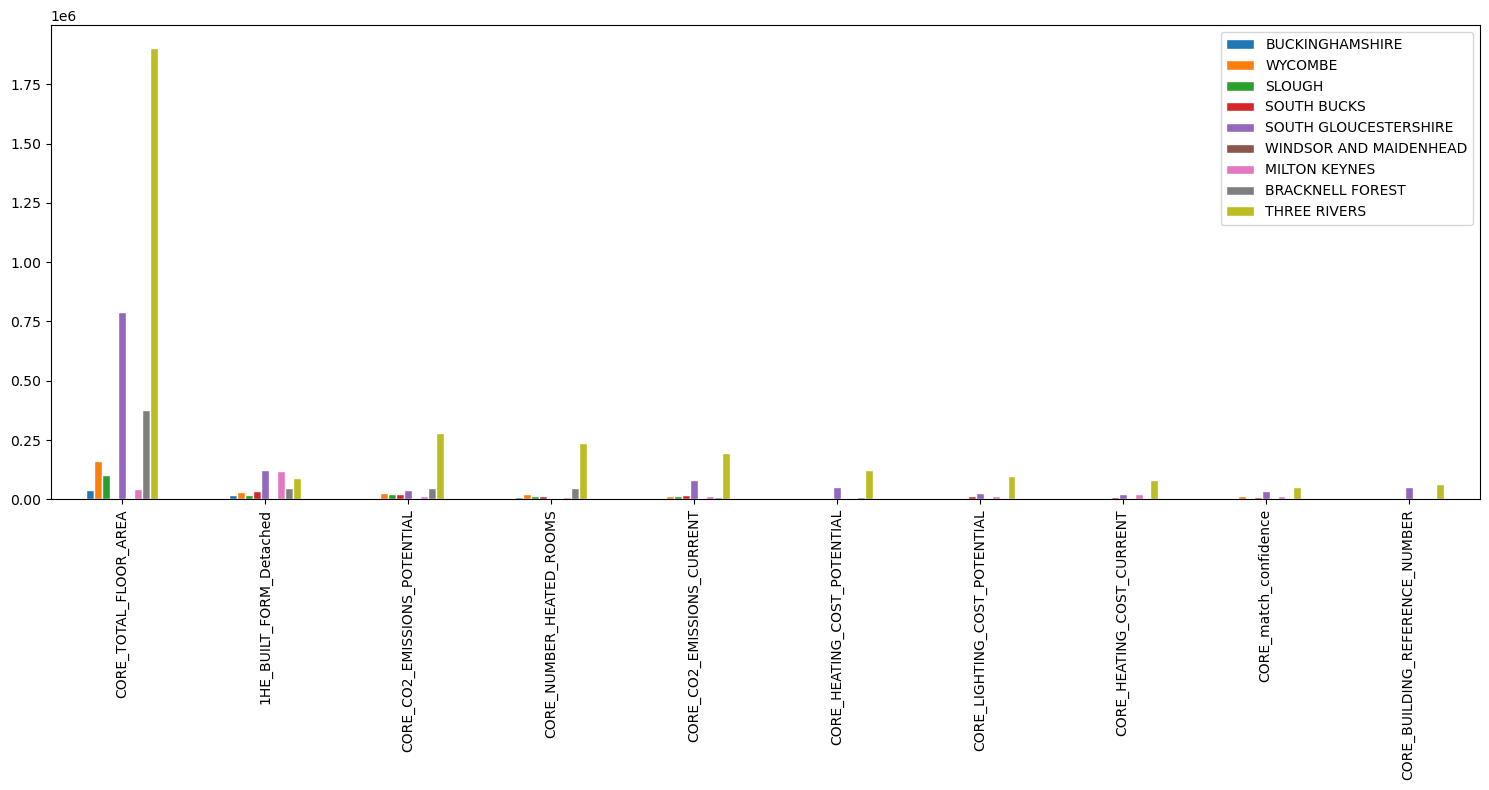

In [46]:
# Plotting the SHAP metrics by District
plt.close('all') # Wipes the residual effect from Matplotlib from previous graphs.
ax = df_plot.T.plot(kind='bar', figsize=(15,8), edgecolor = 'white')

plt.tight_layout()
plt.show()

In [47]:
df_plot.loc[:,df_plot.columns.str.startswith('1HE_district')]

""
BUCKINGHAMSHIRE
WYCOMBE
SLOUGH
SOUTH BUCKS
SOUTH GLOUCESTERSHIRE
WINDSOR AND MAIDENHEAD
MILTON KEYNES
BRACKNELL FOREST
THREE RIVERS


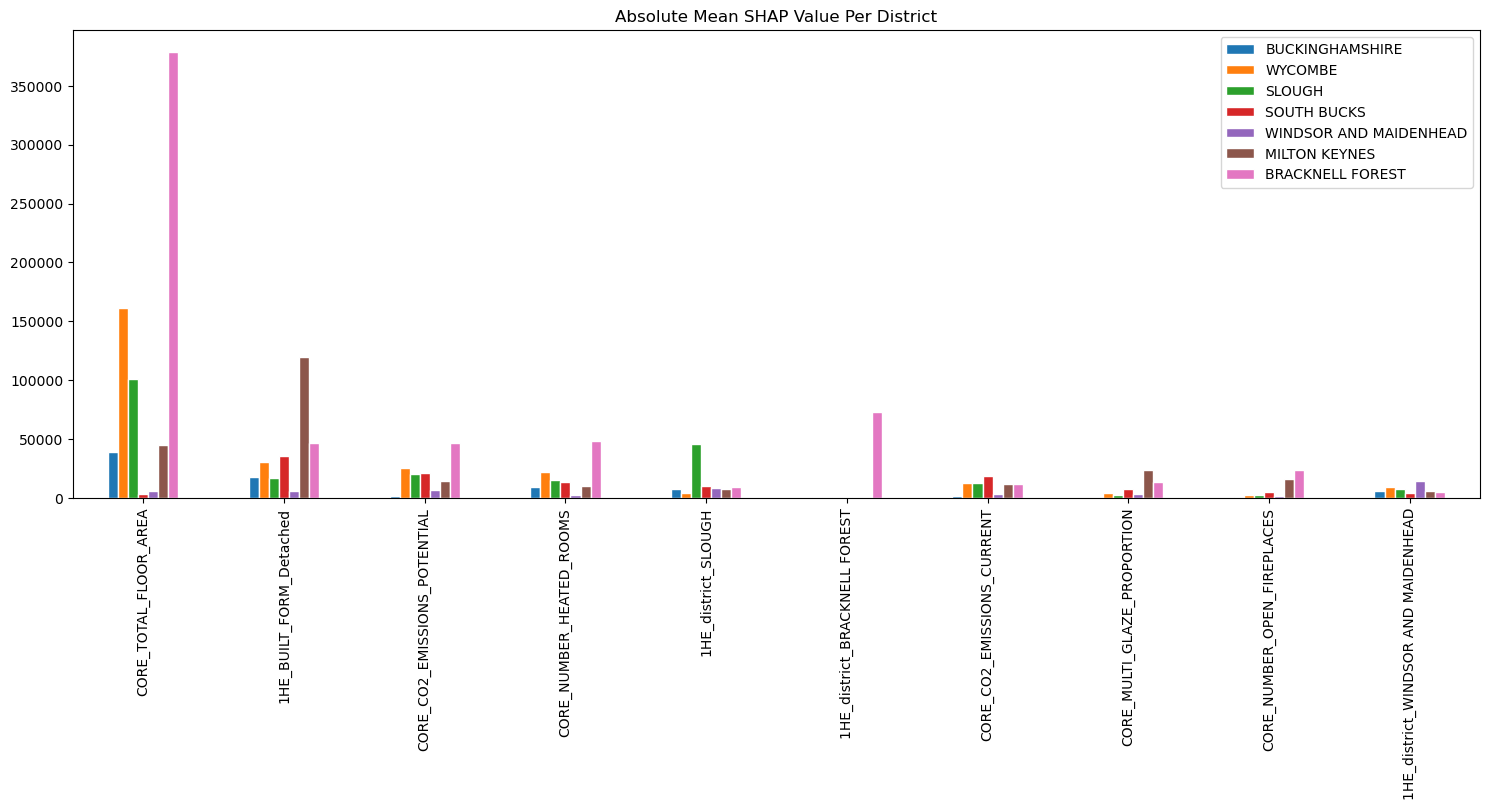

In [48]:
# Removing the two districts with significant SHAP values for Floor Area (for better comparison)
rmv_districts = ['SOUTH GLOUCESTERSHIRE', 'THREE RIVERS']

shap_districts_df_filtered = shap_districts_df.drop(index = rmv_districts)

top_10_features = shap_districts_df_filtered.mean().sort_values(ascending=False).head(10).index
df_plot = shap_districts_df_filtered[top_10_features]

plt.close('all') # Wipes the residual effect from Matplotlib from previous graphs.
ax = df_plot.T.plot(kind='bar', figsize=(15,8), edgecolor = 'white')

plt.tight_layout()
plt.title('Absolute Mean SHAP Value Per District')
plt.savefig('img-outputs/SHAP_District_Comparison.png')
plt.show()